In [1]:
import importlib
import display as disp
import shapes as shp
import shapely as sp
from shapely import affinity as aff
from shapely.geometry import Point, LineString, Polygon, MultiLineString, MultiPolygon
import numpy as np

import ezdxf as ez
import gdstk

In [2]:
importlib.reload(shp)
importlib.reload(disp)

<module 'display' from '/home/matyilona/.DATA/edu/IT/Software/SuperShapelySnakes/display/__init__.py'>

### Parameters

In [3]:
s = 15. #cpwg s
w = 5. #cpwg w
launcher_width = 240. #launcher bondingpad size
launcher_transition = 200. #launcher triangle length
launcher_gap = 60. #gap around bonding pad of launcher
margin = 20. #empty region around edge of WF
WF = 2000. #WF size
hanger_length = 420. #length of hanger piece parallel to feedline
coupling_dist = 3. #distance of hanger from feedline
hanger_offset = 90. #offset of hanger from launcher
hanger_endgap = 23. #length of ditch at open end of resonator
meander_r = 75. #meander radius
L = 7*700+1000+420+4*2*75*np.pi #approx full length of resonator
inlauncher_width = 130 # width on inlauncher triangle base
inlauncher_length = 100 #length of inlauncher triangle
inlauncher_gap = 100 #gap around inlauncher
inlauncher_leggap = 3 #width of legs on inlauncher
samplespaceA = 300 #width of samplespace
samplespaceB = 600 #length of samplespace
pattern_close = w*1.5 #how close to line patterning should start
pattern_far = 100 #how far from line patterning should stop
pattern_partial_keep = .1 #how much of pattern should remain after cutting to keep

### Launcher and feedline

In [4]:
launchL, _, _ = shp.launcher( s, w,
                        launcher_width, launcher_width , launcher_transition, launcher_gap )
launchR = aff.rotate( launchL , angle=180, origin=(0,0) )
b = launchL.bounds
lw = b[2] - b[0]
lh = b[3] - b[1]
launchL = aff.translate( launchL, WF-margin-b[2] , lh/2+margin )
launchR = aff.translate( launchR, lw+margin, lh/2+margin ) #pull in, 50 away from edge

feed_line = LineString(
    ((lw+margin,lh/2+margin),
     (WF-margin-lw,lh/2+margin))
)
feed_lineL, feed_lineR, _, _ = shp.line_to_cpwg( feed_line, s, w )

feedline_with_launchers = MultiPolygon( (launchL, launchR, feed_lineL, feed_lineR ) )

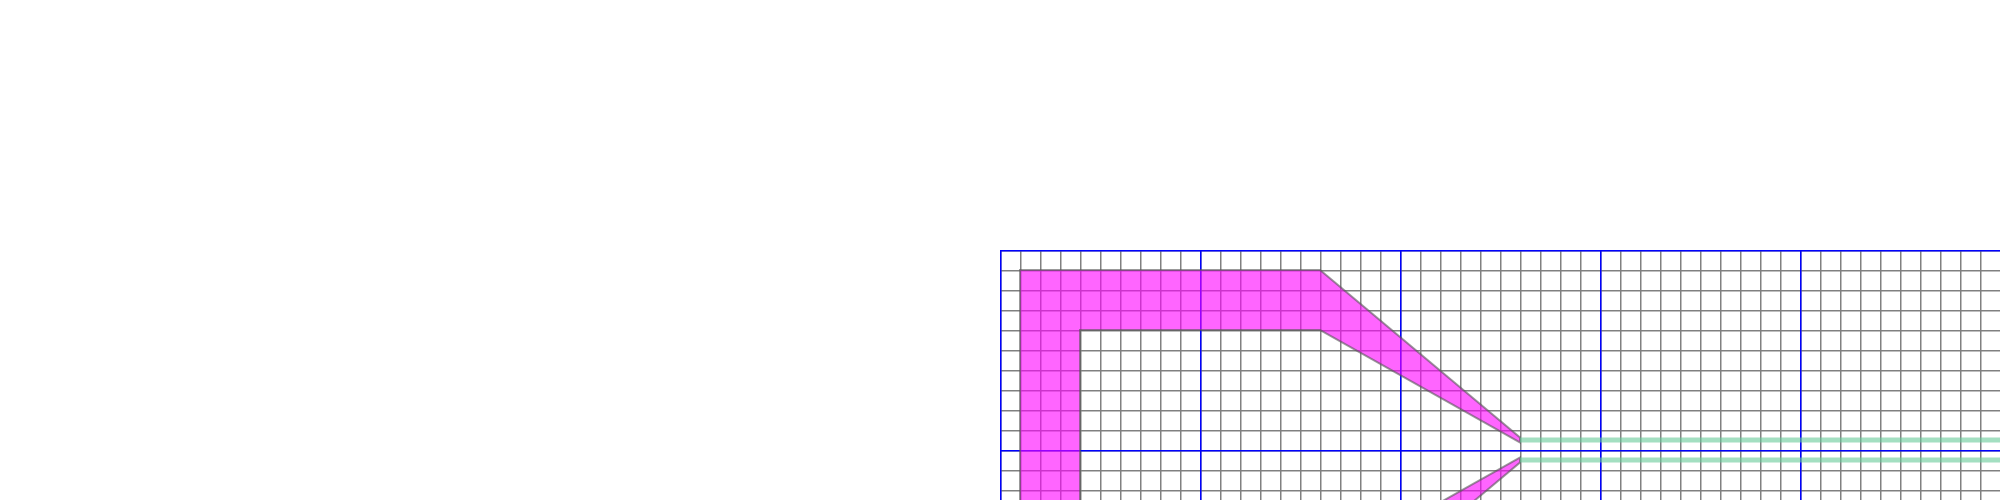

In [5]:
disp.display_svg([
    disp.generate_svg_grid(0,0,WF,WF,20,200,dattrib={"stroke-width":"3"},Dattrib={"stroke-width":"3"}),
    disp.nice_svg( launchL ),
    disp.nice_svg( launchR, attribs={'fill':'#f0f'} ),
    disp.nice_svg( feed_lineL ),
    disp.nice_svg( feed_lineR ),
], (0,0,WF,WF/4)
)

### Resonator and meander

In [6]:

hanger_start = (lw+margin+hanger_offset,lh/2+margin+s+w*2+coupling_dist)
hanger_end = (lw+margin+hanger_offset+hanger_length,lh/2+margin+s+w*2+coupling_dist)
hanger_line = LineString( ( hanger_start, hanger_end ) )
#hanger_lineL, hanger_lineR, _, _ = shp.line_to_cpwg( hanger_line, s, w )
hanger_endcap = shp.box(aff.translate(Point(hanger_end),hanger_endgap/2,0), hanger_endgap, s+2*w)
#hanger = MultiPolygon( (hanger_lineL, hanger_lineR, hanger_endcap) )

connectors = []
connectors.append( shp.circle_segment(
    aff.translate(Point(hanger_start),0,meander_r),
    meander_r, np.pi, np.pi*1.5, 50
) )

l = launchL.bounds[3] - connectors[-1].bounds[3]
connectors.append( LineString([
    connectors[-1].coords[-1],
    aff.translate( Point(connectors[-1].coords[-1]), 0, l ),
]) )

connectors.append( shp.circle_segment(
    aff.translate( Point(connectors[-1].coords[-1]), -meander_r, 0 ),
    meander_r, np.pi/2, 0, 30
) )

connectors.append( LineString([
    connectors[-1].coords[-1],
    [margin+launcher_gap+meander_r, connectors[-1].coords[-1][1]]
]))

connectors.append( shp.circle_segment(
    aff.translate( Point(connectors[-1].coords[-1]), 0, meander_r ),
    meander_r, np.pi, np.pi*1.5, 30
))

connectors.append( LineString([
    Point(connectors[-1].coords[-1]),
    aff.translate( Point(connectors[-1].coords[-1]), 0, meander_r ),
]) )

connector_line = sp.ops.linemerge( connectors )

l = WF-margin-2*(s+w)-meander_r-connectors[-1].bounds[3] #max length of straight pieces
l_res = L - sp.ops.linemerge([hanger_line,connector_line]).length #length of resonator so far
n = int( np.ceil( l_res/(l+np.pi*meander_r) ) ) #number of straight pieces
meander_line = shp.basic_meander_line( l, meander_r, n )
meander_line = aff.affine_transform( meander_line, [0,1,1,0]+list(connectors[-1].coords[-1]) ) #flip, and move to end of connector
resonator_line = sp.ops.linemerge( [hanger_line, connector_line, meander_line] )

diff = resonator_line.length - L + meander_r*np.pi/2+w+s #lengt we have to cut back
meander_line_end = aff.translate( Point(meander_line.coords[-1]), 0, -diff ) #new endpoint
meander_line = LineString( meander_line.coords[:-1]+[meander_line_end] )
resonator_line = sp.ops.linemerge( [hanger_line, connector_line, meander_line] )

inlauncher_connector = shp.circle_segment(
    aff.translate( Point( meander_line.coords[-1] ), meander_r, 0 ),
    meander_r, -np.pi/2, 0, decimals=15
)
inlauncher_straight = LineString([
    inlauncher_connector.coords[-1],
    aff.translate( Point( inlauncher_connector.coords[-1] ), w+s, 0 )
])
resonator_line = sp.ops.linemerge( [resonator_line, inlauncher_connector, inlauncher_straight] )

resonatorL, resonatorR, resonator_lineL, resonator_lineR = shp.line_to_cpwg( resonator_line, s, w )

inlauncher_template = Polygon([
    [0,-w/2],
    [0,w/2],
    [inlauncher_length,inlauncher_gap+inlauncher_width/2-s/2-w/2],
    [inlauncher_length,inlauncher_width/2-s/2-w/2]
])
inlauncherL = aff.translate( inlauncher_template ,*resonator_lineL.coords[-1] )
inlauncherR = aff.affine_transform( inlauncher_template,[1,0,0,-1]+list(resonator_lineR.coords[0]) )

resonator_with_inlauncher = MultiPolygon( [hanger_endcap, resonatorL, resonatorR, inlauncherL, inlauncherR] )

print( f"""
    Length difference: {L-resonator_line.length:.5f}um
    Total length: {resonator_line.length:.2f}um
    """)


    Length difference: 0.14947um
    Total length: 8204.81um
    


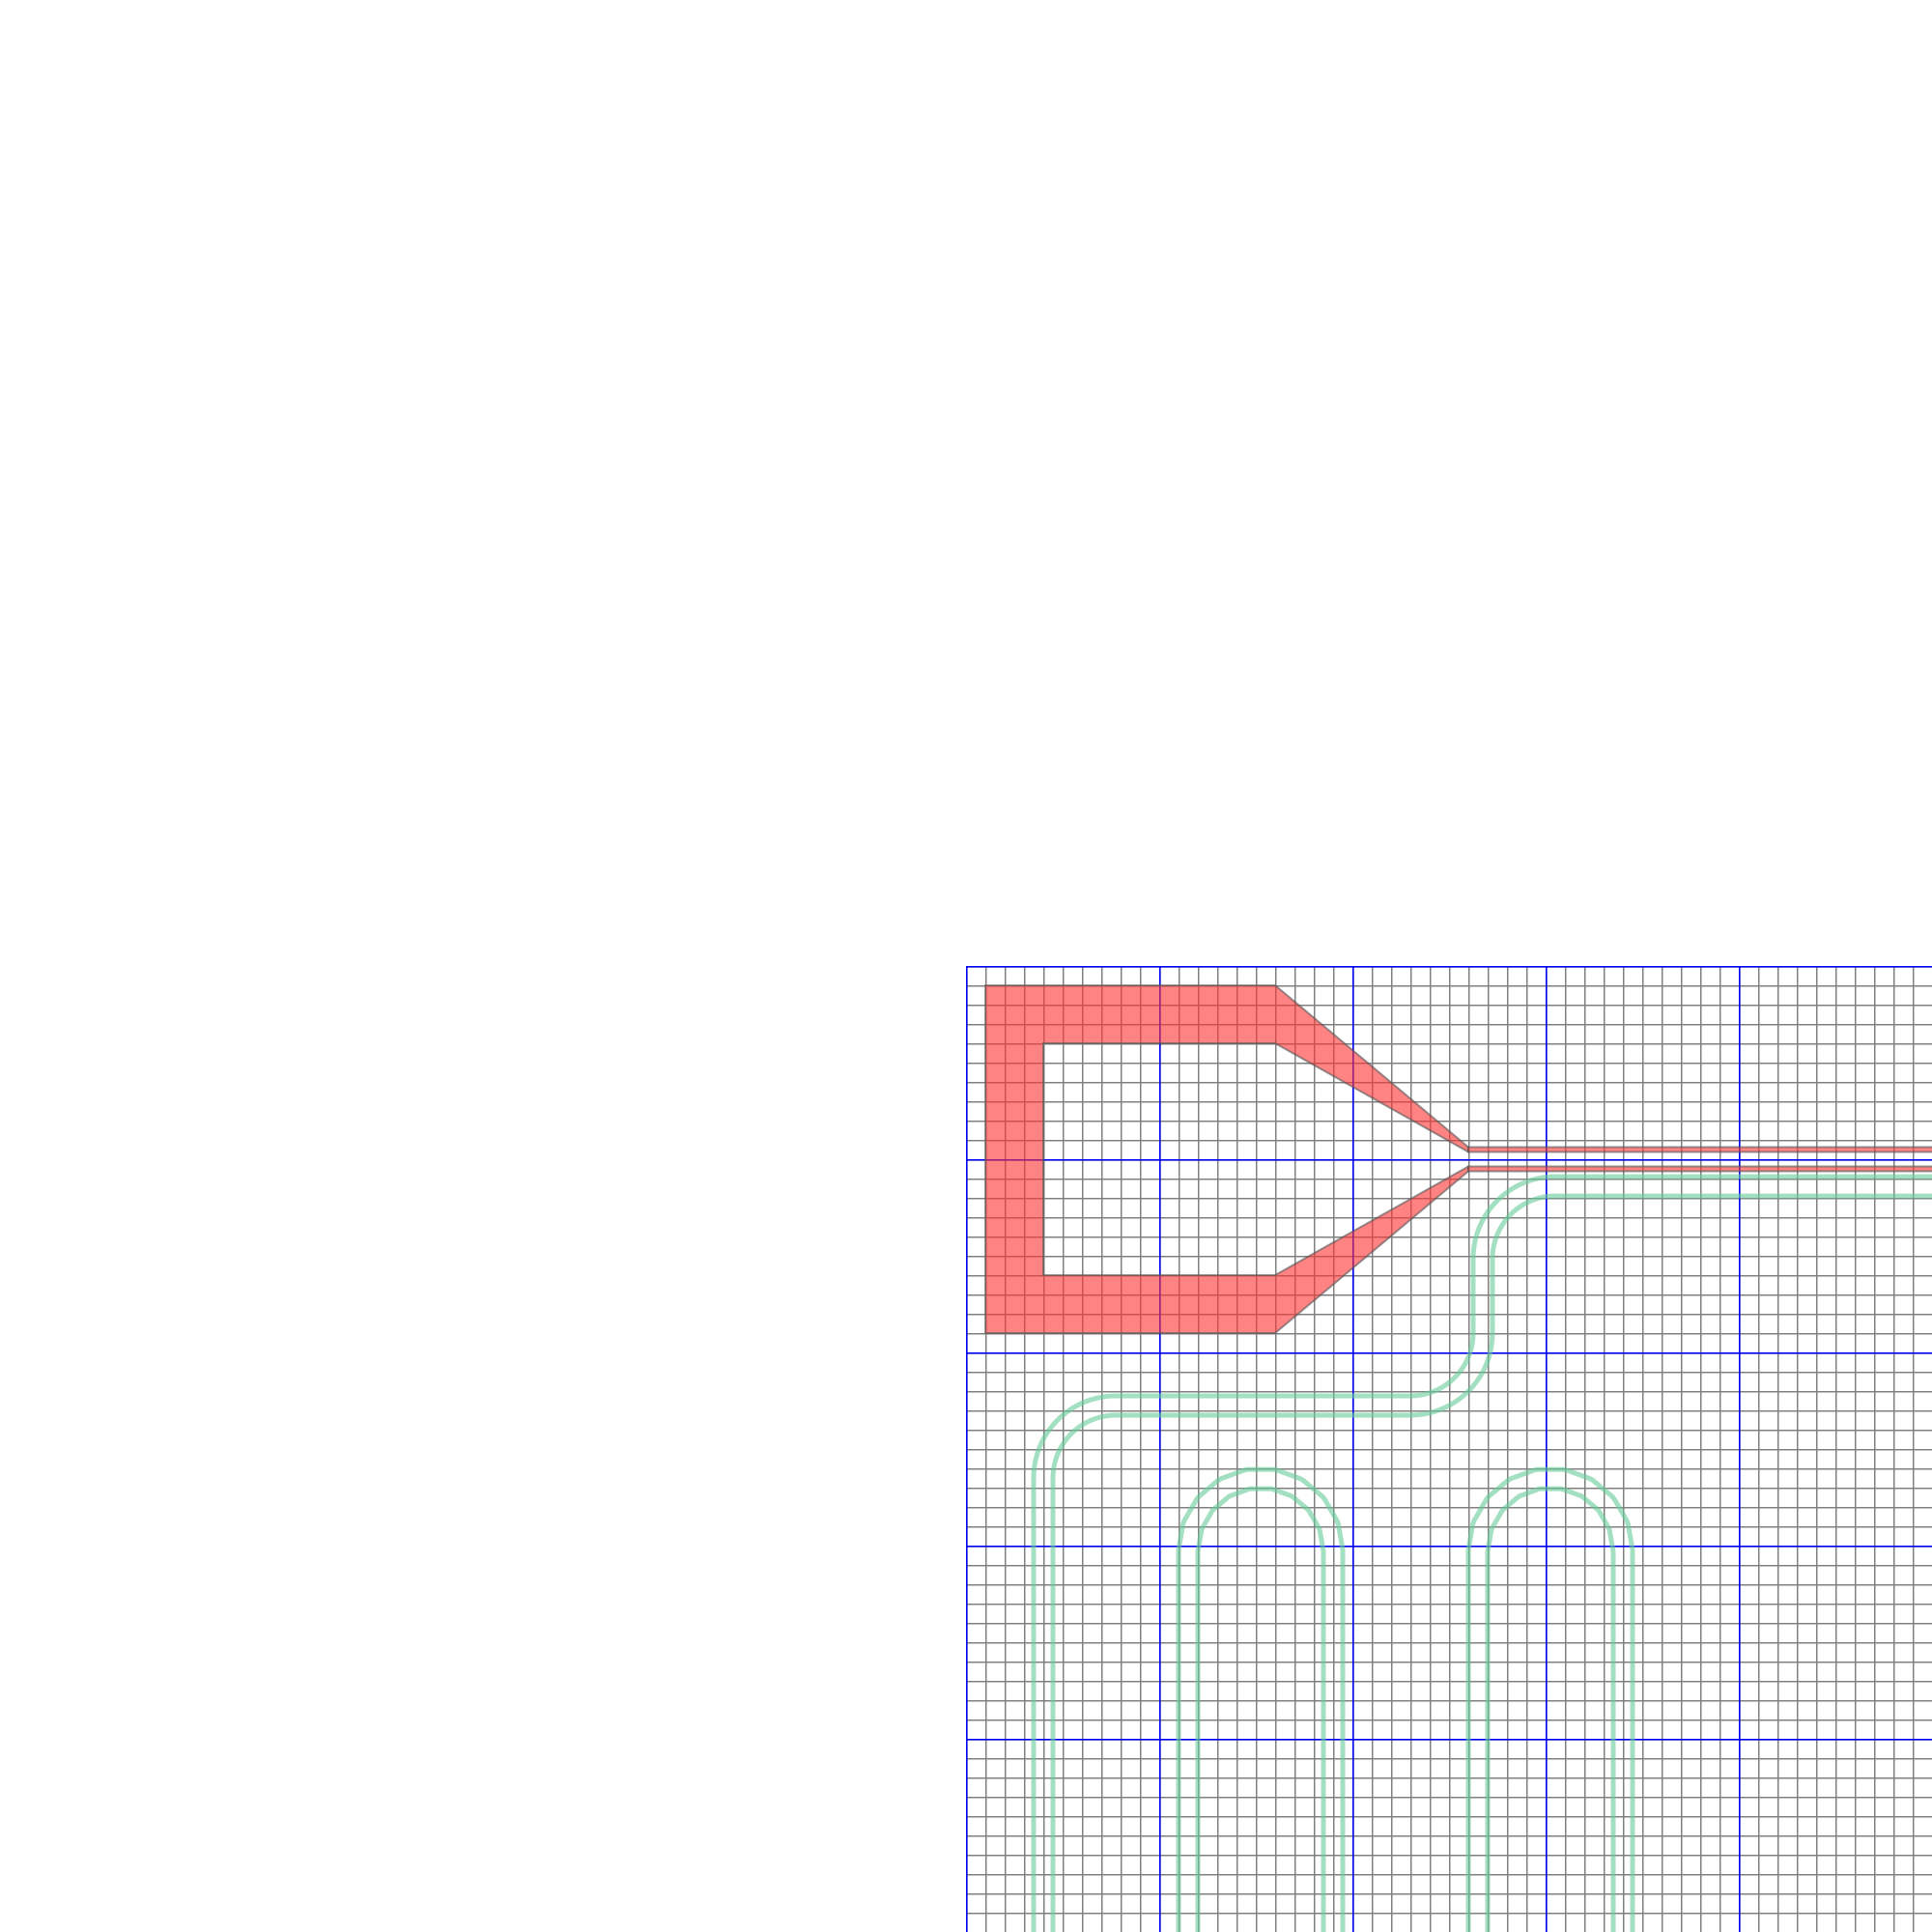

In [7]:
disp.display_svg([
    disp.generate_svg_grid(0,0,WF,WF,20,200,dattrib={"stroke-width":"3"},Dattrib={"stroke-width":"3"}),
    disp.nice_svg( feedline_with_launchers ),
    disp.nice_svg( hanger_endcap ),
    disp.nice_svg( resonatorR ),
    disp.nice_svg( resonatorL ),
    disp.nice_svg( inlauncherR ),
    disp.nice_svg( inlauncherL, attribs={'fill':'#f0f'} ),
    #disp.nice_svg( resonator_line, attribs={'stroke-width':'4'} ),
    #disp.nice_svg( meander_line, attribs={'stroke-width':'4', 'stroke':'#f00'} ),
    #disp.nice_svg( inlauncher_connector, attribs={'stroke-width':'4'} ),
    
], (0,0,WF,WF)
)

### Sample space

In [8]:
samplespace_center = aff.translate( Point(inlauncherL.bounds[2:]), inlauncher_leggap+samplespaceA/2, -samplespaceB/2 )
samplespace = shp.box( samplespace_center, samplespaceA, samplespaceB )

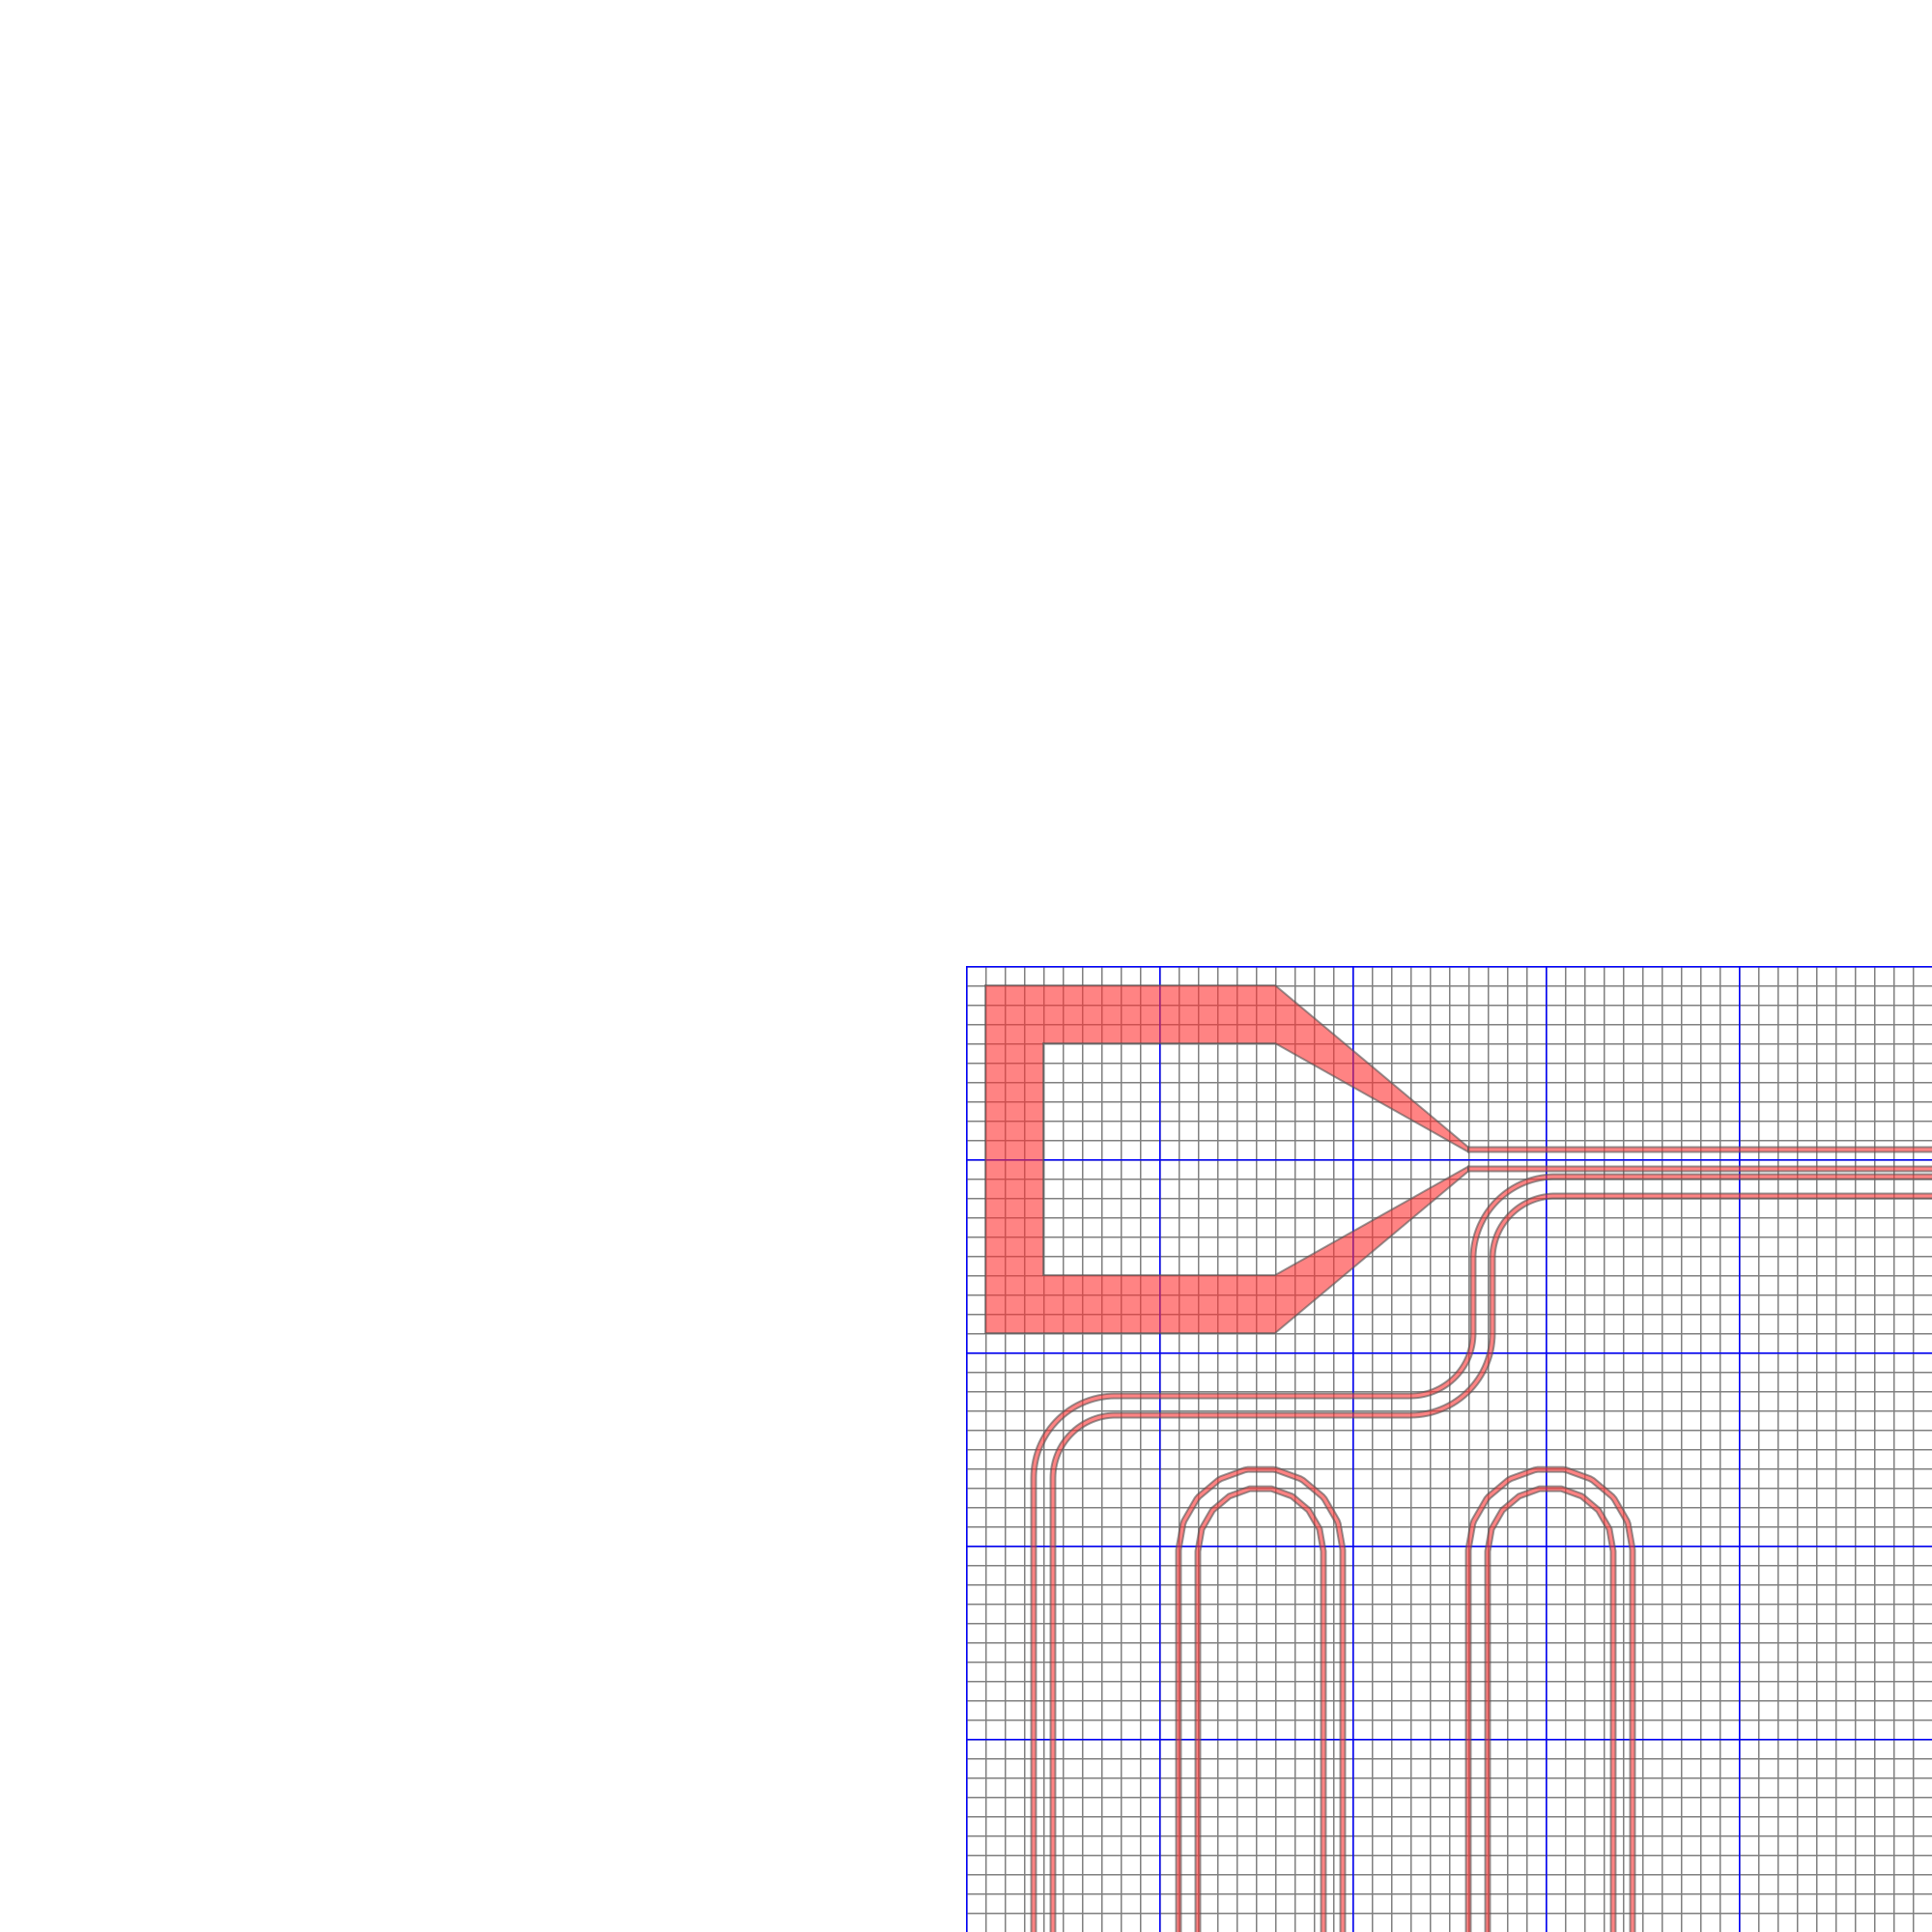

In [9]:
disp.display_svg([
    disp.generate_svg_grid(0,0,WF,WF,20,200,dattrib={"stroke-width":"3"},Dattrib={"stroke-width":"3"}),
    disp.nice_svg( feedline_with_launchers ),
    disp.nice_svg( resonator_with_inlauncher ),
    disp.nice_svg( samplespace ),
    
], (0,0,WF,WF)
)

### Gates, and fluxlines

In [10]:
gate_launchers = [ aff.translate( launchL, 0, (lh+margin*2)*i) for i in range(1,5) ]
launcher_start =[ [l.bounds[0],l.bounds[1]/2+l.bounds[3]/2] for l in gate_launchers ]

flux1_line = [LineString([
    launcher_start[0],
    [samplespace.bounds[0]-3*inlauncher_leggap, launcher_start[0][1]],
])]
flux1_line.append(shp.circle_segment(
    aff.translate( Point(flux1_line[-1].coords[-1]), 0, meander_r ),
    meander_r, np.pi, np.pi*1.5
))
flux1_line.append(LineString([
    flux1_line[-1].coords[-1],
    [flux1_line[-1].coords[-1][0], samplespace.bounds[1]+samplespaceB-inlauncher_gap*2-inlauncher_width-2*meander_r],
]))
flux1_line.append(shp.circle_segment(
    aff.translate( Point(flux1_line[-1].coords[-1]), meander_r, 0 ),
    meander_r, -np.pi*.5, 0, decimals=14
))
flux1_line.append(LineString([
    flux1_line[-1].coords[-1],
    aff.translate( Point(flux1_line[-1].coords[-1]), inlauncher_leggap*2, 0 )
]))
flux1_line = sp.ops.linemerge( flux1_line )
flux1R, flux1L, _, _ = shp.line_to_cpwg( flux1_line, s, w )

flux2_line = LineString([
    launcher_start[2],
    [samplespace.bounds[2]+inlauncher_leggap,launcher_start[2][1]]
])
flux2R, flux2L, _, _ = shp.line_to_cpwg( flux2_line, s, w )

gate1_line = LineString([
    launcher_start[1],
    [samplespace_center.x,launcher_start[1][1]],
    [samplespace_center.x,samplespace.bounds[1]],
])
gate1R, gate1L, _, _ = shp.line_to_cpwg( gate1_line, s, w )

gate2_line = LineString([
    launcher_start[3],
    [samplespace_center.x,launcher_start[3][1]],
    [samplespace_center.x,samplespace.bounds[3]],
])
gate2R, gate2L, _, _ = shp.line_to_cpwg( gate2_line, s, w )

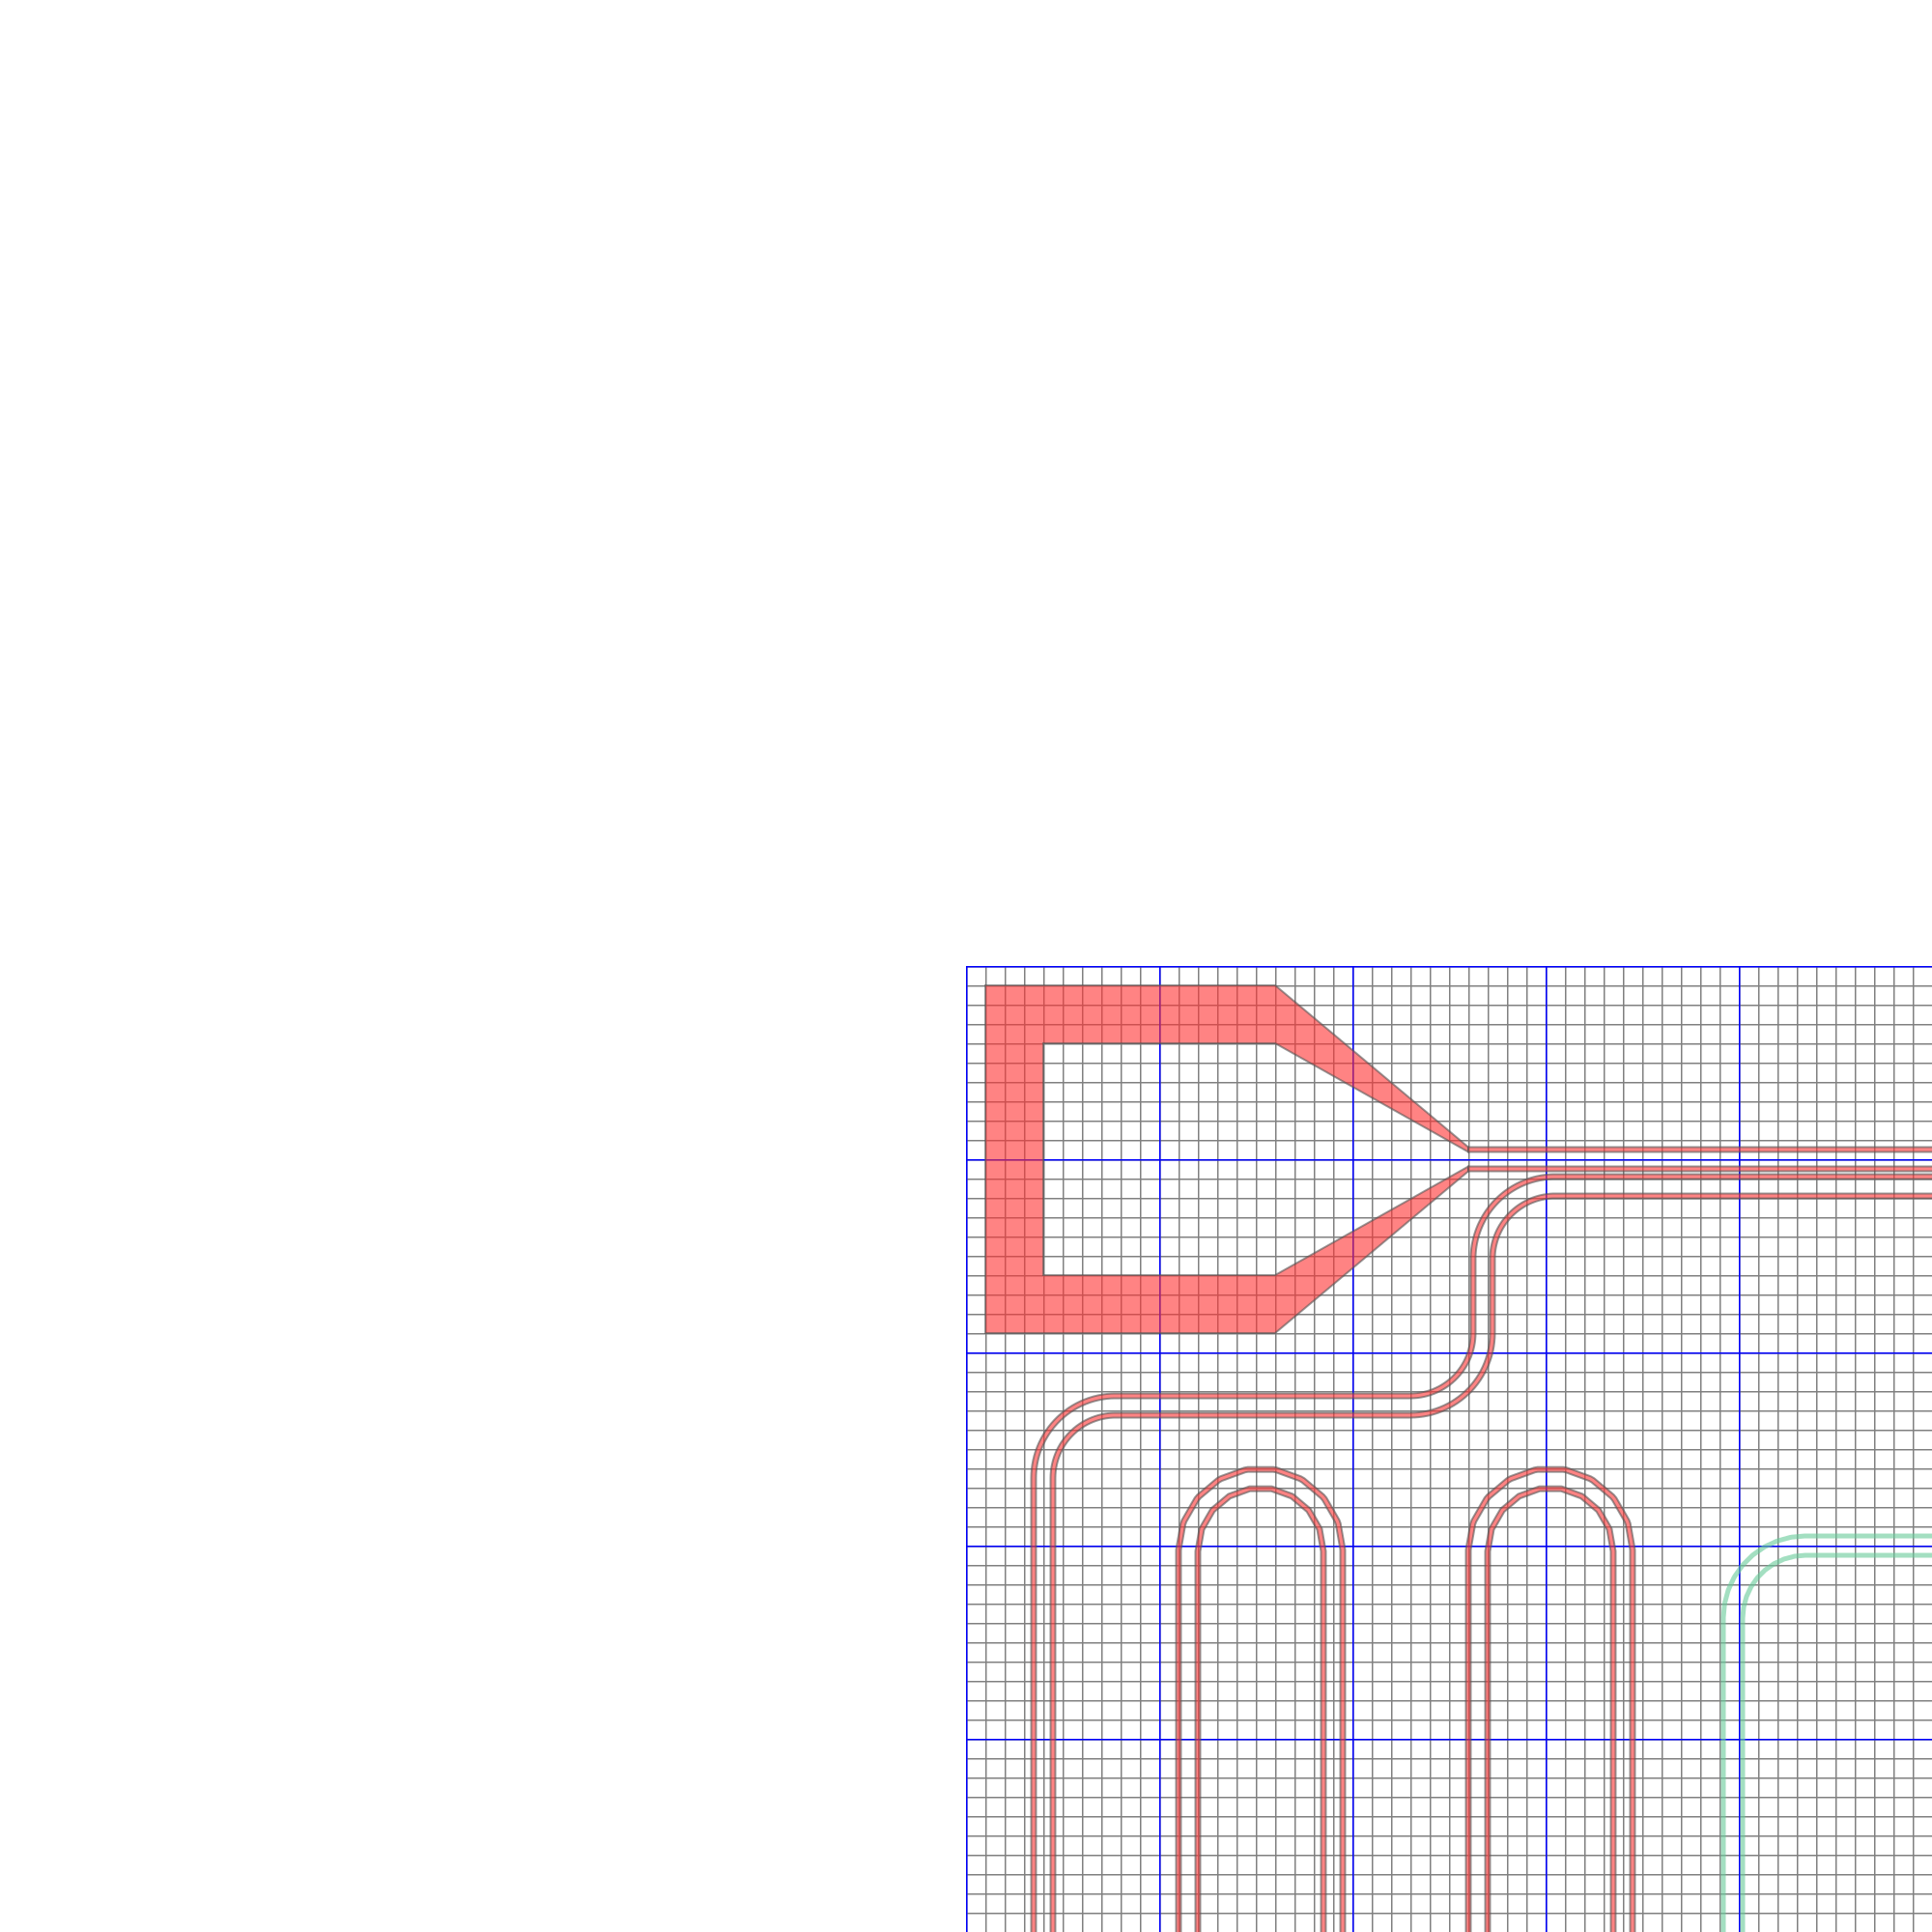

In [11]:
disp.display_svg([
    disp.generate_svg_grid(0,0,WF,WF,20,200,dattrib={"stroke-width":"3"},Dattrib={"stroke-width":"3"}),
    disp.nice_svg( feedline_with_launchers ),
    disp.nice_svg( resonator_with_inlauncher ),
    disp.nice_svg( samplespace ),
    *[disp.nice_svg( l ) for l in gate_launchers ],
    #disp.nice_svg( gate1_line, attribs={'stroke-width':'4'}),
    disp.nice_svg( flux1L ),
    disp.nice_svg( flux1R ),
    disp.nice_svg( flux2L ),
    disp.nice_svg( flux2R ),
    disp.nice_svg( gate1L ),
    disp.nice_svg( gate1R ),
    disp.nice_svg( gate2L ),
    disp.nice_svg( gate2R ),
    
    
], (0,0,WF,WF)
)

### Patterning

In [12]:
#squares = shp.generate_squares( 20, 25, (margin,margin,WF-margin*2,WF-margin*2) )
squares = shp.generate_squares( 20, 25, (0,0,WF,WF) )
launchers = MultiPolygon([
    launchL.convex_hull,
    launchR.convex_hull,
    *[ l.convex_hull for l in gate_launchers ]
])
samplezone = MultiPolygon([
    samplespace,
    #MultiPolygon( [inlauncherL, inlauncherR] ).convex_hull,
    inlauncherL,
    inlauncherR
])
lines = MultiLineString([
    feed_line,
    resonator_line,
    flux1_line, flux2_line,
    gate1_line, gate2_line,
])
patt_zone = sp.ops.unary_union([
    *launchers,
    *samplezone,
    *lines.buffer(s/2+w),
    hanger_endcap
]).buffer(pattern_close)

squares = [ sq.difference( patt_zone ) for sq in squares if patt_zone.distance( sq ) < pattern_far ]
squares = [ sq for sq in squares if sq.area > pattern_partial_keep*20*20]

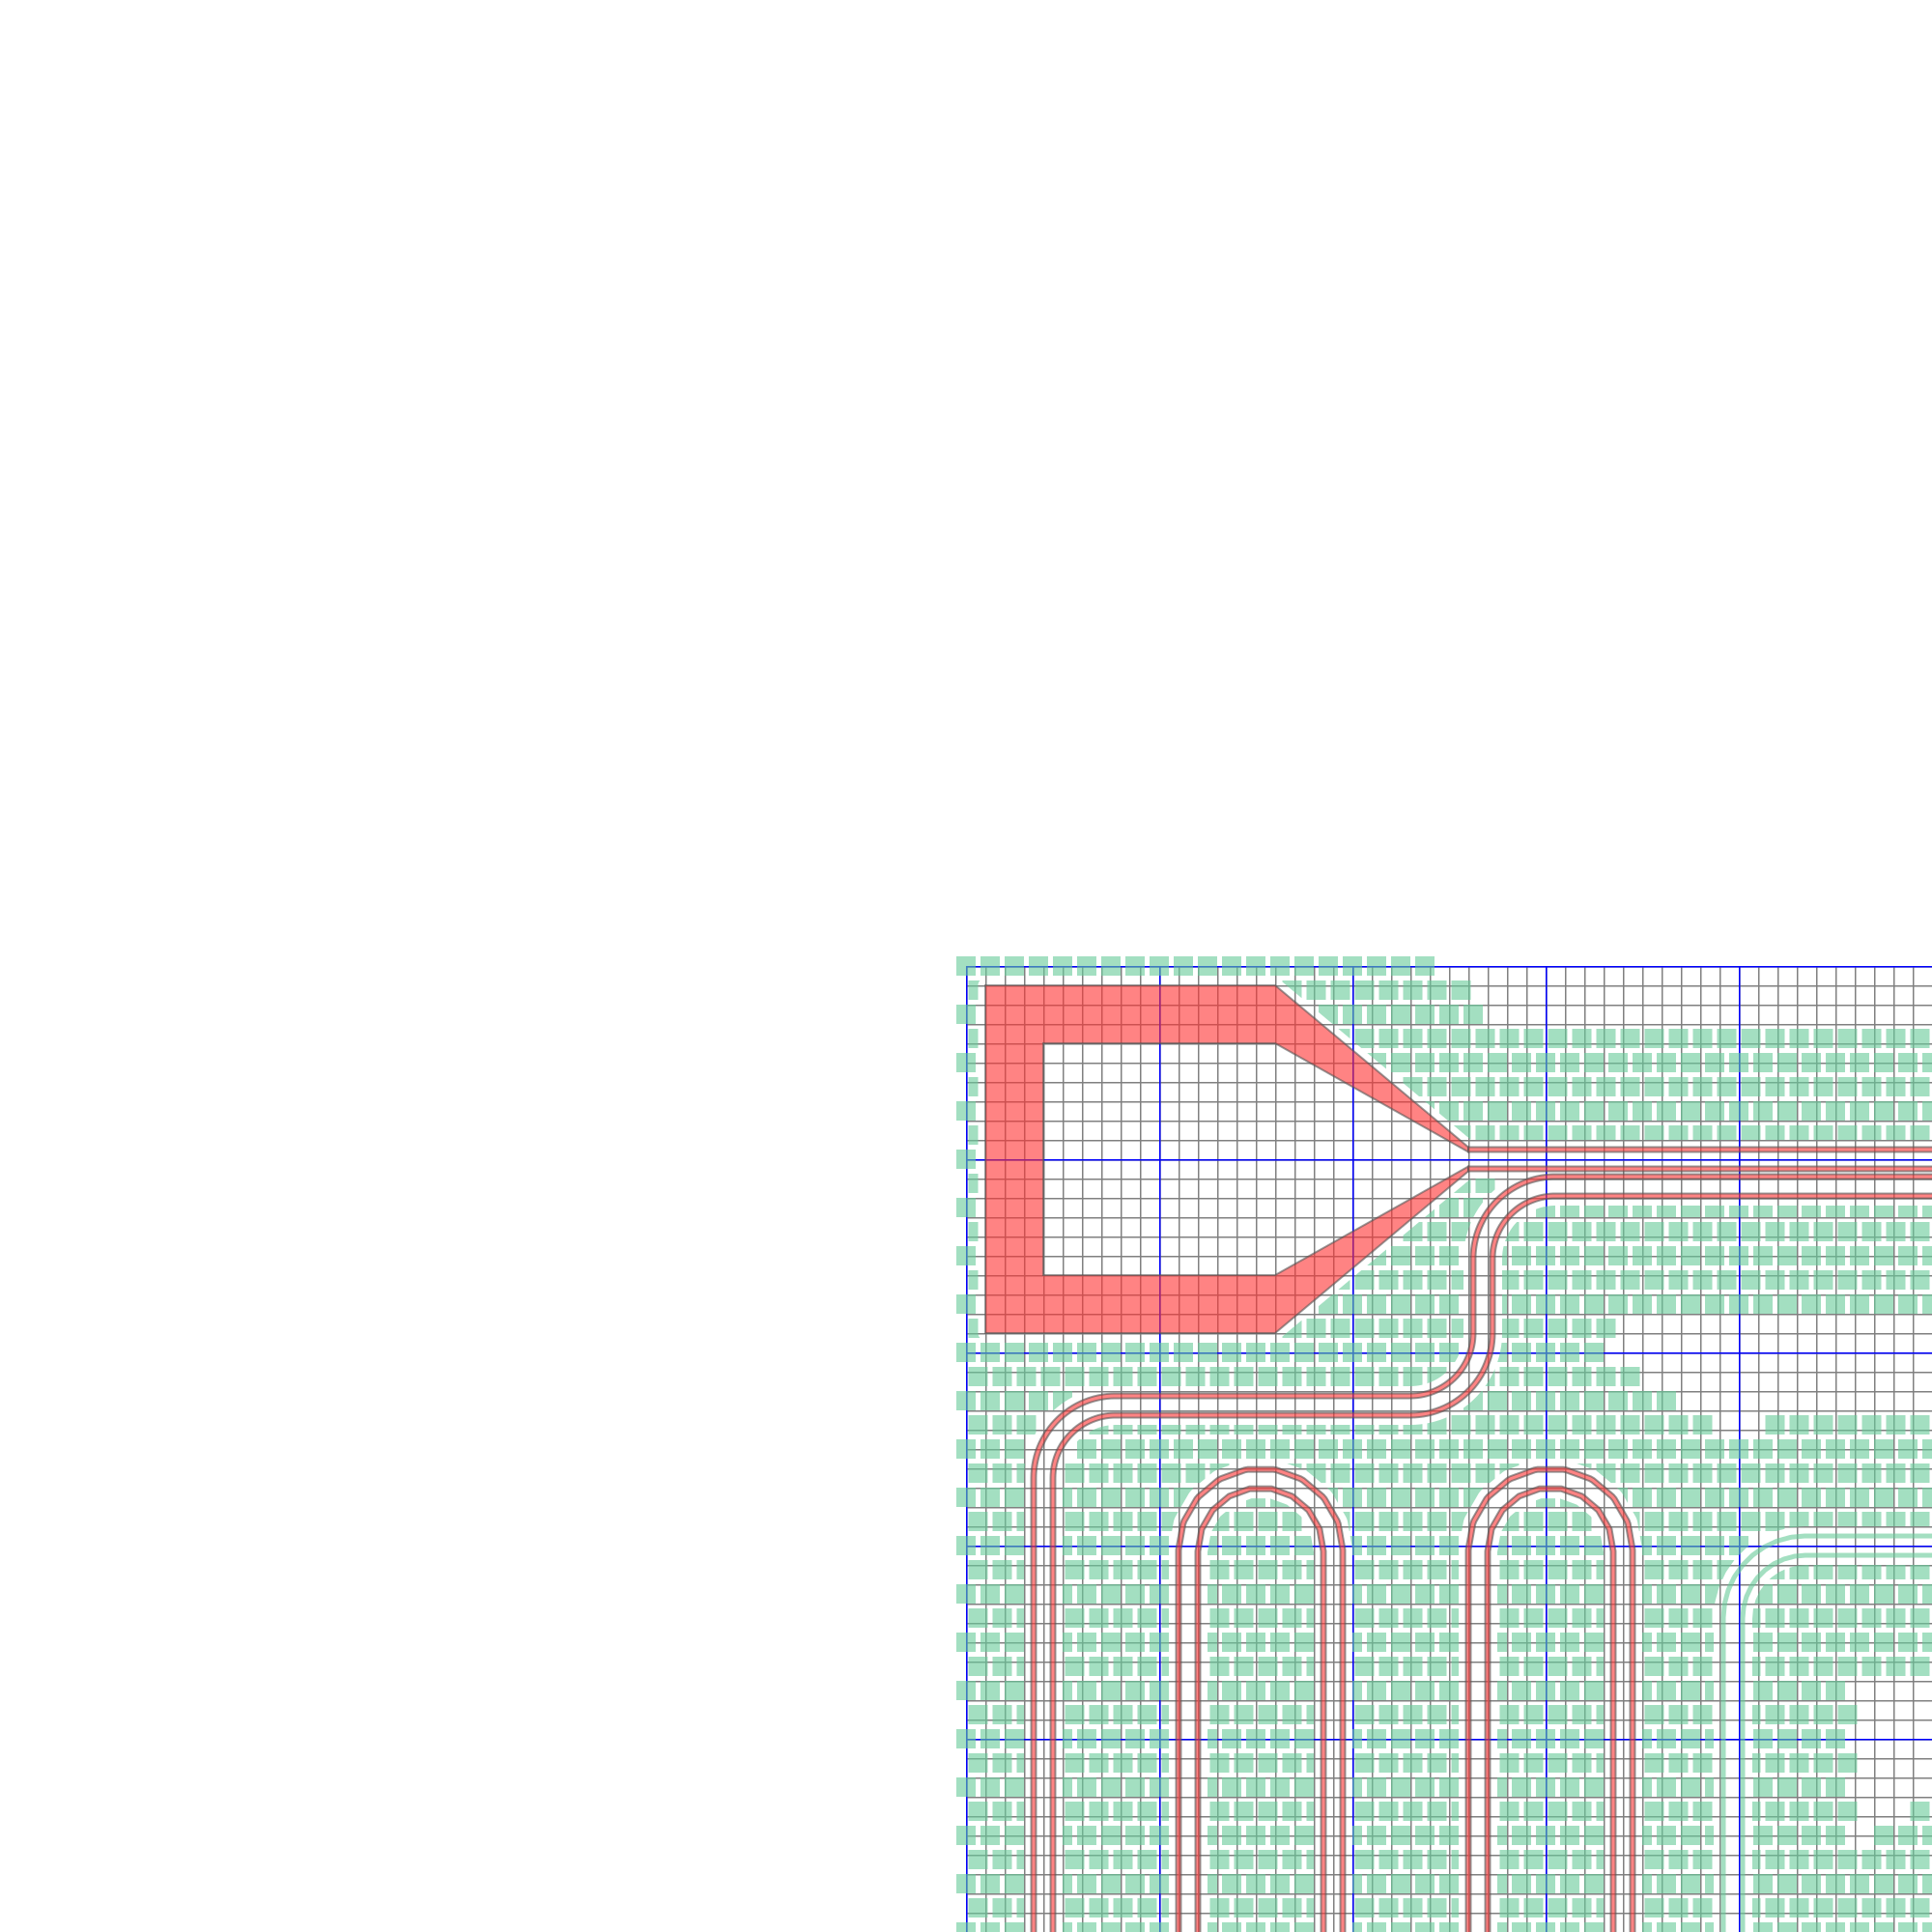

In [13]:
disp.display_svg([
    disp.generate_svg_grid(0,0,WF,WF,20,200,dattrib={"stroke-width":"3"},Dattrib={"stroke-width":"3"}),
    #disp.nice_svg( patt_zone ),
    *[disp.nice_svg(sq) for sq in squares],
    disp.nice_svg( feedline_with_launchers ),
    disp.nice_svg( resonator_with_inlauncher ),
    disp.nice_svg( samplespace ),
    *[disp.nice_svg( l ) for l in gate_launchers ],
    #disp.nice_svg( gate1_line, attribs={'stroke-width':'4'}),
    disp.nice_svg( flux1L ),
    disp.nice_svg( flux1R ),
    disp.nice_svg( flux2L ),
    disp.nice_svg( flux2R ),
    disp.nice_svg( gate1L ),
    disp.nice_svg( gate1R ),
    disp.nice_svg( gate2L ),
    disp.nice_svg( gate2R ),
    
], (0,0,WF,WF)
)

In [14]:
def poly_to_dxf( polys, doc):
    msp = doc.modelspace()
    for i in range(len(polys)):
        x, y = polys[i].exterior.xy
        x_y = list(zip(x, y))
        x_y.append( [x[0], y[0]] )
        msp.add_lwpolyline(x_y)

In [15]:
doc = ez.new()
poly_to_dxf([
    *[sq for sq in squares],
    *feedline_with_launchers,
    *resonator_with_inlauncher,
    samplespace,
    *[ l  for l in gate_launchers ],
    #disp.nice_svg( gate1_line, attribs={'stroke-width':'4'}),
    flux1L, flux1R,
    flux2L, flux2R,
    gate1L, gate1R,
    gate2L, gate2R,
    
], doc)
doc.saveas("SaclayStyle-2G2Fv1.dxf")

In [39]:
def poly_to_gds( poly, layer=0 ):
    gds = gdstk.Polygon( list(zip(*poly.exterior.xy) ))
    gds.layer = layer
    return( gds )

In [40]:
lib = gdstk.Library()
cell = lib.new_cell("Main")
for sq in squares:
    cell.add( poly_to_gds(sq, layer=0) )
for p in feedline_with_launchers:
    cell.add( poly_to_gds(p, layer=1) )
for p in resonator_with_inlauncher:
    cell.add( poly_to_gds(p, layer=2) )
cell.add( poly_to_gds(samplespace, layer=3) )
for p in [gate_launchers[0], flux1L, flux1R]:
    cell.add( poly_to_gds(p, layer=4) )
for p in [gate_launchers[2], flux2L, flux2R]:
    cell.add( poly_to_gds(p, layer=5) )
for p in [gate_launchers[1], gate1L, gate1R]:
    cell.add( poly_to_gds(p, layer=6) )
for p in [gate_launchers[3], gate2L, gate2R]:
    cell.add( poly_to_gds(p, layer=7) )

In [41]:
lib.write_gds("SaclayStyle-2G2Fv1-gdstk.gds")